In [3]:
import numpy as np
import xarray as xr
import sklearn as sk
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
v4 = xr.open_dataset('/loc6tb/data/responses/v4cnn/apc370t.nc', chunks={'unit':2})['resp']
v4.coords['unit'] = range(109)

fn = 'bvlc_reference_caffenetpix_width[ 8.4096606]_x_(64, 164, 51)_y_(114.0, 114.0, 1)PC370'

da = xr.open_dataset('/loc6tb/data/responses/v4cnn/' + fn + '.nc')['resp']
da = da.sel(unit=slice(0, None, 1)).squeeze()
middle = np.round(len(da.coords['x'])/2.).astype(int)
da_0 = da.sel(x=da.coords['x'][middle])    
net = da_0 

fn = '/loc6tb/data/models/apc_models_362.nc'
apc = xr.open_dataset(fn, chunks={'models':50, 'shapes':370})['resp']
apc['models'] = range(apc.shape[1])

FileNotFoundError: [Errno 2] No such file or directory: '/loc6tb/data/responses/v4cnn/apc370t.nc'

I would like to reveal the relationship of stimulus tuning to time. One difficult that I will run into how the signal to noise ratio relates to time:

- Dynamic range and variability are different across neurons.

- Dynamic range changes over time.

- Variability changes over time.


How can I take this into account in my analysis of tuning over time:

- remove SNR bias: use an unbiased estimator of correlation with respect to Dynamic range and variability.

- improve SNR: remove stimuli which are detrimental to the estimation of correlation.

My null hypothesis is that differences in tuning can largely be attributed to differences in dynamic range and variability.

What are my questions?

- Does tuning change over time?
- Do the quality of fits change over time?

In [1]:
v4s = v4.loc[..., 50:150].sum('t').load()

NameError: name 'v4' is not defined

In [5]:
m = v4s.mean('trial', skipna=True)
v = (v4s.var('trial', skipna=True, ddof=1))

In [ ]:
vm = (v/m).mean('stim')
r = (m**0.5).var('stim', skipna=True)


In [ ]:
v4s = v4[49].dropna('trial', how='any').loc[..., 50:500].sum('t').load()
x = v4s.values 
print(x)
print(x.shape)
#expect stimXtrial
m = x.mean(1) 
v = x.var(1, ddof=1) 
ind = (m>1)*(v>1)
m = m[ind]
v = v[ind]

print(m.shape)
ml = np.log10(m)
vl = np.log10(v)
intercept= np.ones(len(m))

A = np.vstack([ml, intercept]).T


b_est, c = np.linalg.lstsq(A, vl)[0]

print(b_est)
print(10**c)

plt.scatter(m,v);
plt.axis('square')
plt.ylim(np.min(m)*0.9, np.max(v)*1.1);plt.xlim(np.min(m)*0.9, np.max(v)*1.1);
#plt.plot([1,100], [1,100], color='r')
xs = np.linspace(np.min(m), np.max(m), 100)
plt.plot(xs, (10**c)*xs**b_est, color='r')

In [109]:
import pandas as pd
def power_fit(v4, ts, te):
    fits = np.zeros((v4.shape[0], 2))
    for i, av4 in enumerate(v4):
        x = av4.dropna('trial', how='any').loc[..., ts:te].sum('t').load().values
        m = x.mean(1) 
        v = x.var(1, ddof=1) 
        ind = (m>1)*(v>1)
        if (x.shape[1]>1) and (np.sum(ind)>10):
            m = m[ind]
            v = v[ind]

            ml = np.log10(m)
            vl = np.log10(v)
            intercept= np.ones(len(m))

            A = np.vstack([ml, intercept]).T


            b_est, c = np.linalg.lstsq(A, vl)[0]
            b = b_est
            a = 10.**c

            fits[i] = np.array([a,b]) 
        else:
            fits[i] = np.array([np.nan, np.nan])
    fits = pd.DataFrame(fits, columns=['slp', 'exp'])
    return fits
ts=50
te=150
fits = power_fit(v4, ts, te)

/home/dean/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/dean/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater


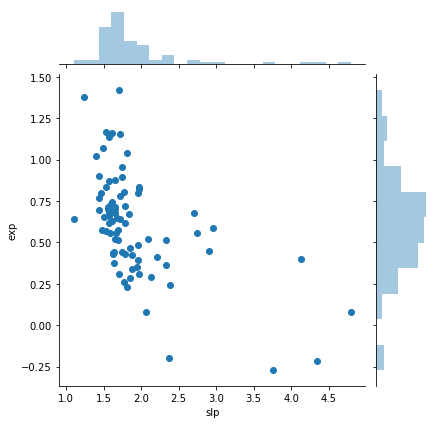

In [110]:
sns.jointplot(x='slp', y='exp', data=fits)

In [197]:
t = v4.coords['t'].values
dur = max(t) - min(t)
nbins = np.floor(dur/50.)
bins = np.arange(min(t), max(t), 50)

v4b = v4.groupby_bins('t', bins=bins, labels=bins[:-1]).sum('t').load()
beta = (v4b.sum('trials', skipna=True)**0.5).var('shapes').load()

111


/home/dean/anaconda2/lib/python2.7/site-packages/xarray/plot/facetgrid.py:118: UserWarning: Ignoring col_wrap since both col and row were passed
  warnings.warn('Ignoring col_wrap since both col and row '


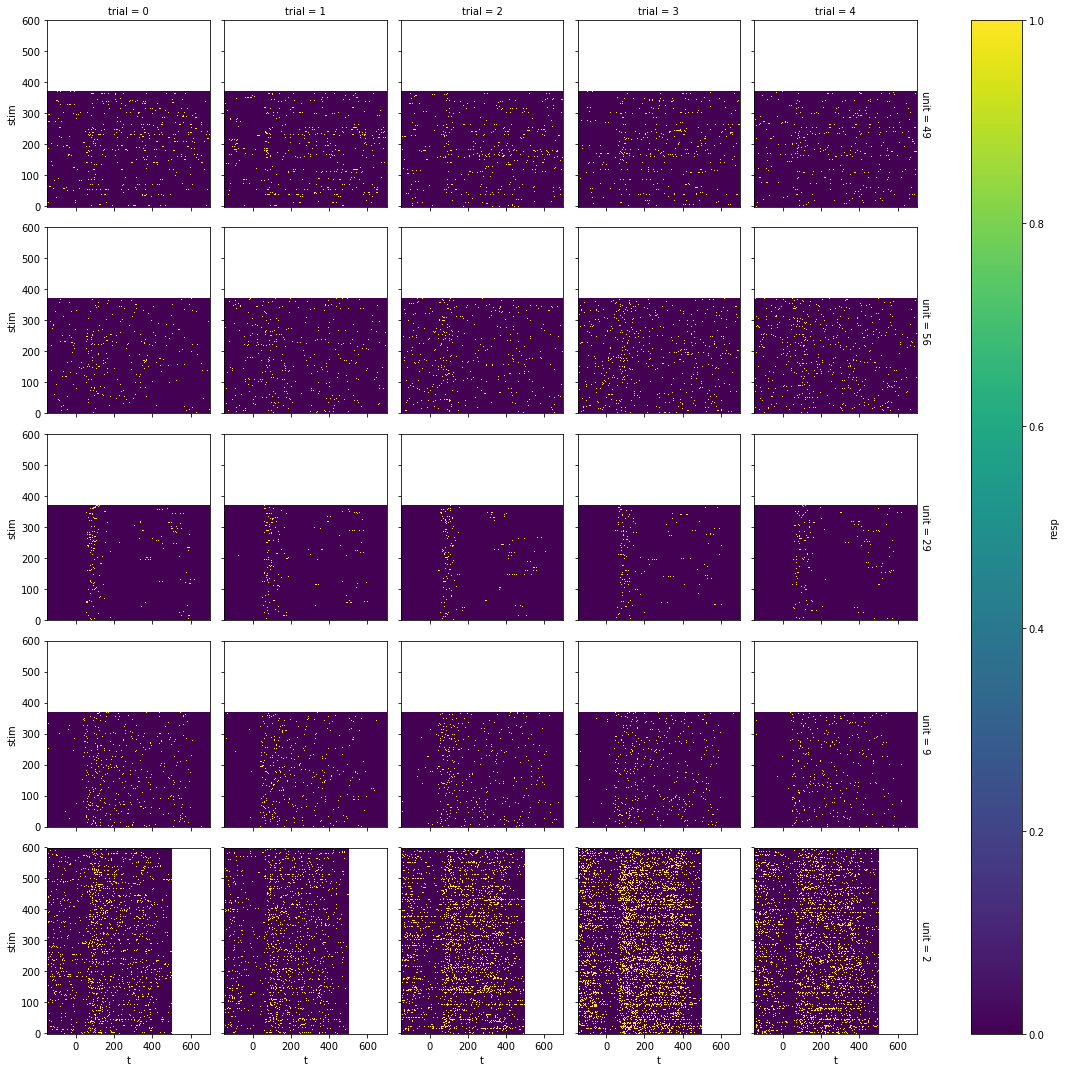

In [74]:
ind = r.argsort().values
i=-1
print(ind[i])
v4[ind[-10:], :, :5].plot(x='t', y='stim', col='trial',row='unit')

In [75]:
alpha = beta.loc[...,0:].sum('t_bins').values/beta.loc[...,0:].sum('t_bins').values.max()
top_cells = np.argsort(alpha)[::-1][:7]
plt.figure(figsize=(8,8))
plt.subplot(212)

beta[top_cells].plot.line('--o', x='t_bins', add_legend=True, alpha=1);plt.ylabel('dynamic range')
plt.xticks(bins + (bins[1] - bins[0])/2.)
plt.xticks(bins - (bins[1] - bins[0])/2.)
plt.gca().set_xticklabels(bins,rotation=90)
plt.title('top')

plt.subplot(211)

beta.mean('unit').plot.line('--o', x='t_bins', add_legend=True, alpha=1);plt.ylabel('dynamic range')
(beta.std('unit') +beta.mean('unit') ).plot.line('--', x='t_bins', alpha=1);plt.ylabel('dynamic range')
plt.title('avg');plt.ylim(0,1.5)
plt.xticks(bins - (bins[1] - bins[0])/2., rotation=90)
plt.gca().set_xticklabels(bins)
plt.plot([-50,450],[.2, .2]);
plt.legend(['mean', 'mean+sd', 'stim on'])

plt.tight_layout()

NameError: name 'beta' is not defined

As a general rule for these stimuli tuning is strongest at the onset, and reduces over time. There was a cell with an interesting 

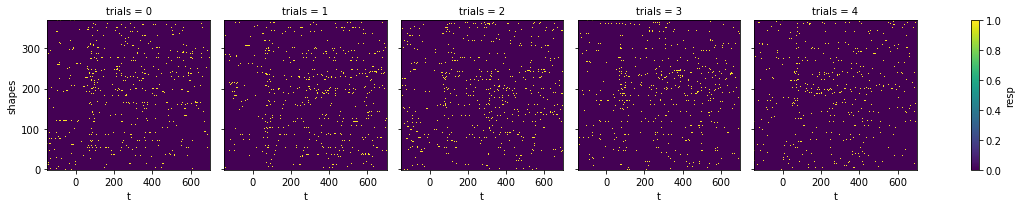

In [288]:
v4[49, :, :5].plot(x='t', y='shapes', col='trials', col_wrap=5)

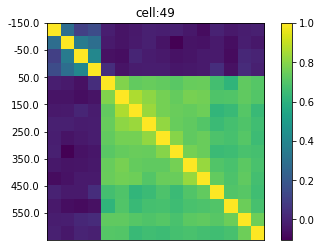

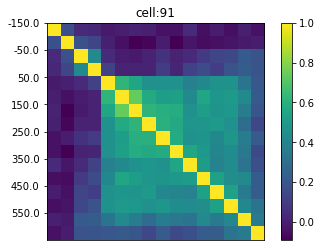

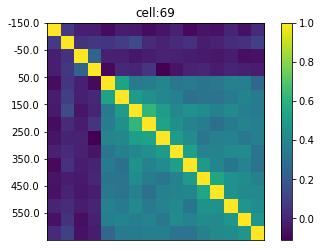

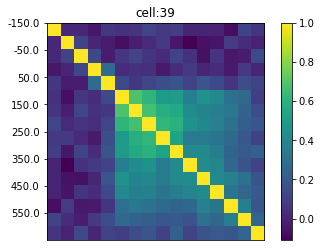

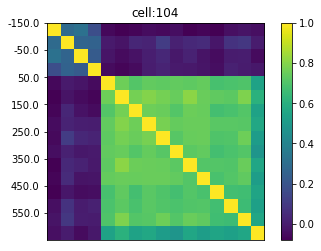

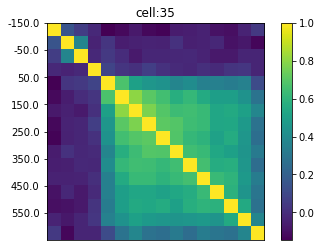

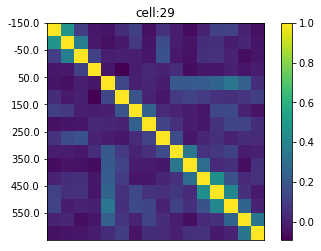

In [206]:
for i in top_cells:
    plt.figure()
    plt.imshow(np.corrcoef(v4bm[i].T));plt.colorbar();
    plt.yticks(np.arange(len(bins)-1)[::2]-0.5);
    plt.gca().set_yticklabels(np.round(bins[:-1])[::2], rotation=0)
    plt.xticks([])
    plt.title('cell:' + str(i))

    
    
    

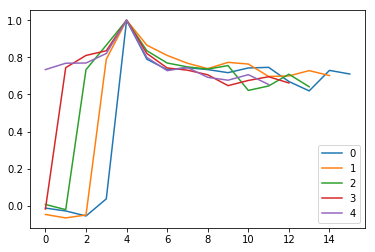

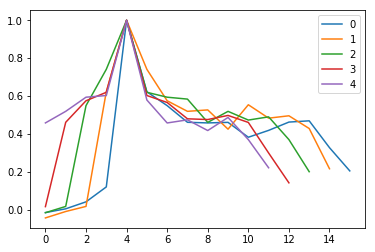

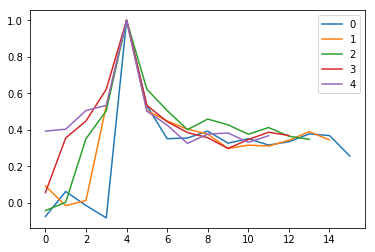

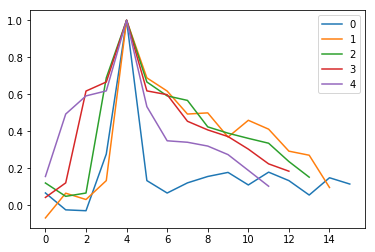

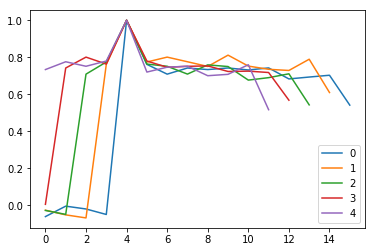

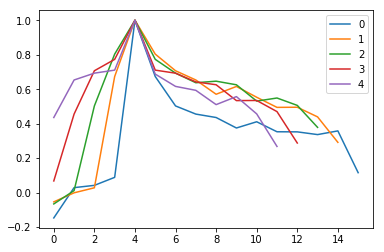

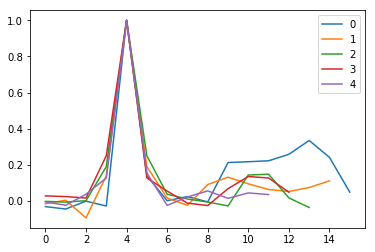

In [287]:
for cell in top_cells:
    plt.figure()
    for i in range(0,5, 1):
        plt.plot(np.corrcoef(v4bm[cell].T)[4+i,i:])
    plt.legend(range(5))
